In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler ,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import LSTM,Dropout, BatchNormalization, Dense
import talib

In [2]:
# Get the data for the SPY ETF by specifying the stock ticker, start date, and end date
dataset = yf.download('0005.hk',"2020-09-28","2021-09-24")
dataset.columns

[*********************100%***********************]  1 of 1 completed


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [3]:
dataset['H-L'] = dataset['High'] - dataset['Low']
dataset['O-C'] = dataset['Close'] - dataset['Open']
dataset['3day MA'] = dataset['Close'].shift(1).rolling(window = 3).mean()
dataset['10day MA'] = dataset['Close'].shift(1).rolling(window = 10).mean()
dataset['30day MA'] = dataset['Close'].shift(1).rolling(window = 30).mean()
dataset['Std_dev']= dataset['Close'].rolling(5).std()
dataset['RSI'] = talib.RSI(dataset['Close'].values, timeperiod = 9)
dataset['Williams %R'] = talib.WILLR(dataset['High'].values, dataset['Low'].values, dataset['Close'].values, 7)

In [4]:
dataset.isnull().sum()

Open            0
High            0
Low             0
Close           0
Adj Close       0
Volume          0
H-L             0
O-C             0
3day MA         3
10day MA       10
30day MA       30
Std_dev         4
RSI             9
Williams %R     6
dtype: int64

In [5]:
dataset.dropna(inplace=True)
dataset.isnull().sum()

Open           0
High           0
Low            0
Close          0
Adj Close      0
Volume         0
H-L            0
O-C            0
3day MA        0
10day MA       0
30day MA       0
Std_dev        0
RSI            0
Williams %R    0
dtype: int64

In [6]:
# data[0:5,0:4]
dataset.drop(["Adj Close"],axis=1,inplace=True)
data_price=dataset["Close"]

In [7]:
train = dataset[0:int(len(dataset)*0.80)].values
# scl = MinMaxScaler()
# #Scale the data
# scl.fit(train.values.reshape(-1,1))
# cl =scl.transform(cl.values.reshape(-1,1))
sc = MinMaxScaler(feature_range=(0,1))
train=sc.fit_transform(train)
def processData(data,data_price,lb):
    X,Y = [],[]
    for i in range(len(data)-lb-1):
        X.append(data[i:(i+lb)])
        Y.append(data_price[(i+lb)])
    return np.array(X),np.array(Y)

lb=3
X,y = processData(train,data_price,lb)
X_train,X_test = X[:int(X.shape[0]*0.90)],X[int(X.shape[0]*0.90):]
y_train,y_test = y[:int(y.shape[0]*0.90)],y[int(y.shape[0]*0.90):]
print(X_train.shape[0],X_train.shape[1])
print(X_test.shape[0], X_test.shape[1])
print(y_train.shape[0])
print(y_test.shape[0])

150 3
17 3
150
17


In [8]:
print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(150, 3, 13) (150,) (17, 3, 13) (17,)


In [9]:
model = keras.Sequential()
model.add(LSTM(units=128,input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dense(units=64,  activation="relu"))
# model.add(Dense(units=32, activation="relu"))
# model.add(Dense(units=8, activation="relu"))
model.add(Dense(units=1))
# model.add(keras.layers.LSTM(
#   units=128,
#   input_shape=(X_train.shape[1], X_train.shape[2])
# ))
# model.add(keras.layers.Dense(units=1))
model.compile(
  loss='mean_squared_error',
  optimizer=keras.optimizers.Adam(learning_rate=0.001)
)

In [10]:
#Fit model with history to check for overfitting
history = model.fit(X_train,y_train,epochs=300,validation_data=(X_test,y_test),shuffle=False)
 
model.summary() 

Epoch 1/300
5/5 [==============================] - 1s 64ms/step - loss: 2010.4363 - val_loss: 1913.9467
Epoch 2/300
5/5 [==============================] - 0s 5ms/step - loss: 1966.4042 - val_loss: 1872.0691
Epoch 3/300
5/5 [==============================] - 0s 4ms/step - loss: 1915.0350 - val_loss: 1819.0604
Epoch 4/300
5/5 [==============================] - 0s 5ms/step - loss: 1846.6637 - val_loss: 1744.8400
Epoch 5/300
5/5 [==============================] - 0s 5ms/step - loss: 1750.1283 - val_loss: 1637.0006
Epoch 6/300
5/5 [==============================] - 0s 5ms/step - loss: 1616.7732 - val_loss: 1487.6003
Epoch 7/300
5/5 [==============================] - 0s 5ms/step - loss: 1449.3010 - val_loss: 1305.9006
Epoch 8/300
5/5 [==============================] - 0s 6ms/step - loss: 1265.3938 - val_loss: 1118.5748
Epoch 9/300
5/5 [==============================] - 0s 5ms/step - loss: 1089.4066 - val_loss: 951.9384
Epoch 10/300
5/5 [==============================] - 0s 5ms/step - loss: 9

In [11]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,
#     batch_size=16,
#     validation_split=0.1,
#     verbose=1,
#     shuffle=False
# )

In [12]:
y_pred = model.predict(X_test)

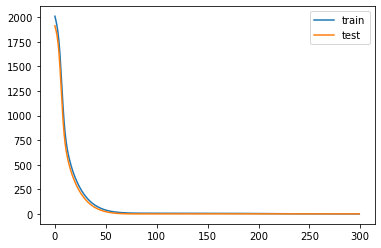

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()

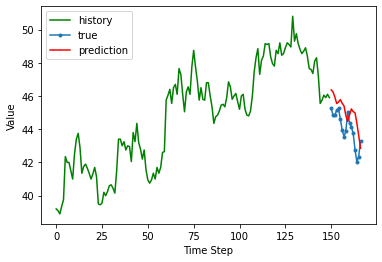

In [14]:
plt.plot(np.arange(0, len(y_train)), y_train, 'g', label="history")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test, marker='.', label="true")
plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();

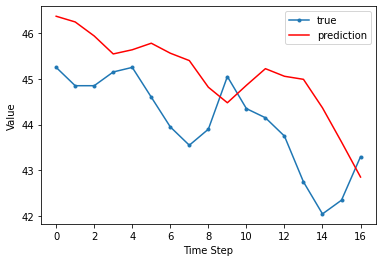

In [15]:
plt.plot(y_test, marker='.', label="true")
plt.plot(y_pred, 'r', label="prediction")
plt.ylabel('Value')
plt.xlabel('Time Step')
plt.legend()
plt.show();